First of all, set the 'CODE_DIR' to where the model code are saved. This will change current working directory and print for checking. Afterwards, we import all required modules.

In [1]:
import os
import torch
# !cd /lustre/fsn1/projects/rech/ggs/uri15na/3_code/styleGAN/pSp_encoder_constructive
CODE_DIR = '/lustre/fsn1/projects/rech/ggs/uri15na/3_code/styleGAN/pSp_encoder_constructive'
os.chdir(f'{CODE_DIR}')
notebook_path = os.getcwd()
print('Current working directory is:', '\n', notebook_path, '\n') 

Current working directory is: 
 /lustre/fsn1/projects/rech/ggs/uri15na/3_code/styleGAN/pSp_encoder_constructive 



In [2]:
from base_functions.base_funcs import set_cuda_arch_list, show_images, display_images
# set cuda variable
set_cuda_arch_list()
# !rm -rf $WORK/.cache/torch_extensions
# !rm -rf ~/.cache/torch_extensions

device='cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

Detected GPU: Tesla V100-SXM2-16GB
Setting TORCH_CUDA_ARCH_LIST to 7.0 for V100
device: cuda


In [4]:
from base_functions.model_funcs import load_pSp_cmlp_models
from base_functions.data_funcs import reproduce_latent_hdf5, get_latent_dataloader, HDF5LatentDataset
from base_functions.base_funcs import seed_experiments
from torch.utils.data import Dataset, DataLoader


In [6]:
model_path = './results/baseline/iteration_130000.pt'
latent_hdf5_path = 'results/baseline/cmlp130k_latent'

pSp_net, cs_mlp_net, opts = load_pSp_cmlp_models(model_path, device=device)

train_hdf5_path = f"{latent_hdf5_path}/train_latents.h5"
val_hdf5_path = f"{latent_hdf5_path}/val_latents.h5"



Loading pSp from checkpoint: ../pretrained_models/pSp_models/psp_ffhq_encode.pt
Loading csmlp from path: ./results/baseline/iteration_130000.pt


In [7]:
latent_keys = ["w_pSp_bg", "w_pSp_t", "latent_bg_c", "latent_bg_s", "latent_t_c", "latent_t_s"]

In [12]:
# Initialize dataset
train_dataset = HDF5LatentDataset(train_hdf5_path, latent_keys)
train_latent_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataset = HDF5LatentDataset(val_hdf5_path, latent_keys)
val_latent_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)


In [18]:
# Get one batch from the train dataloader
w_pSp_bg, w_pSp_t, latent_bg_c, latent_bg_s, latent_t_c, latent_t_s = next(iter(val_latent_dataloader))
w_pSp_bg, w_pSp_t, latent_bg_c, latent_bg_s, latent_t_c, latent_t_s = \
w_pSp_bg.to(device), w_pSp_t.to(device), latent_bg_c.to(device), latent_bg_s.to(device), latent_t_c.to(device), latent_t_s.to(device)
            
# Print shapes to verify
print(f"latent_bg_c shape: {latent_bg_c.shape}")
print(f"latent_bg_s shape: {latent_bg_s.shape}")
print(f"latent_t_c shape: {latent_t_c.shape}")
print(f"latent_t_s shape: {latent_t_s.shape}")


latent_bg_c shape: torch.Size([4, 18, 512])
latent_bg_s shape: torch.Size([4, 18, 512])
latent_t_c shape: torch.Size([4, 18, 512])
latent_t_s shape: torch.Size([4, 18, 512])



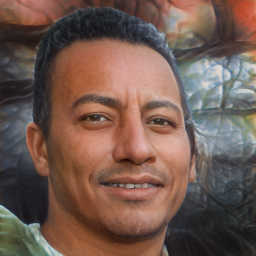
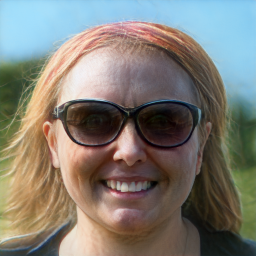
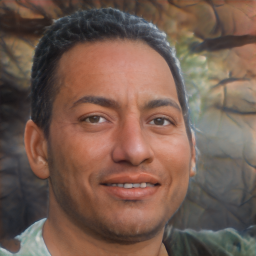
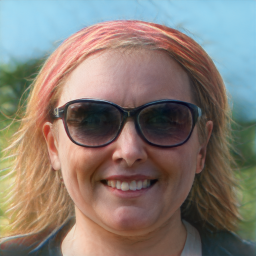
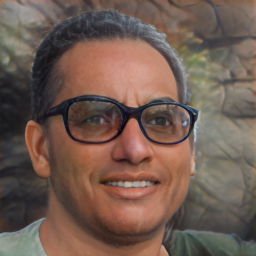
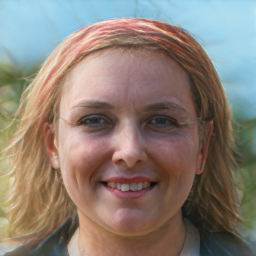


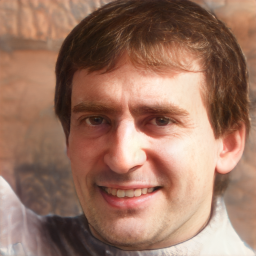
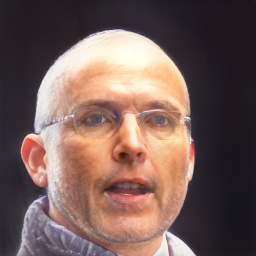
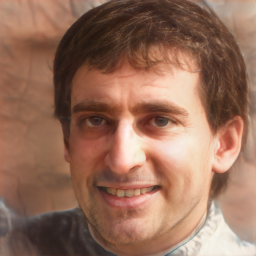
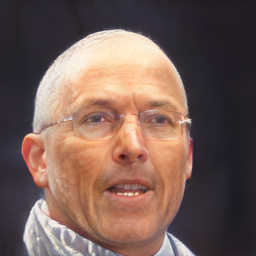
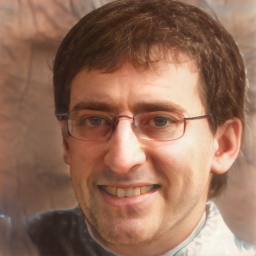
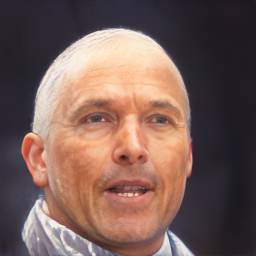


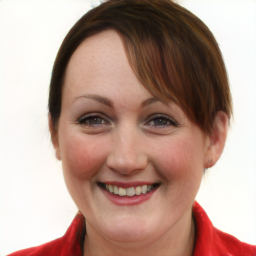
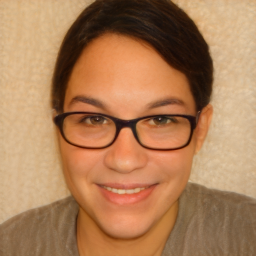
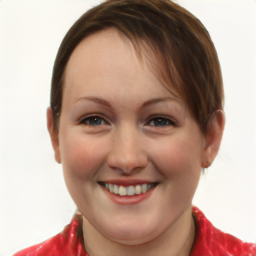
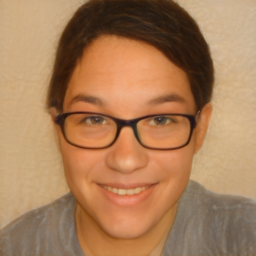
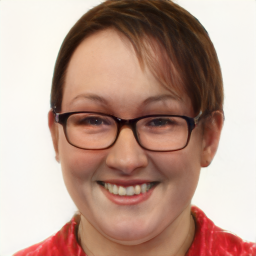
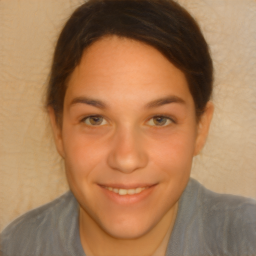


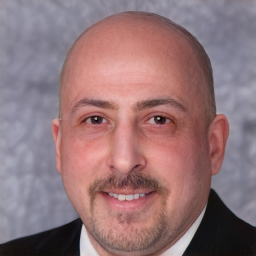
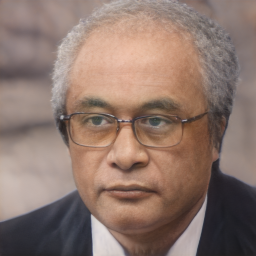
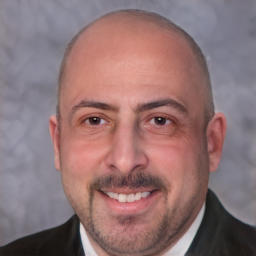
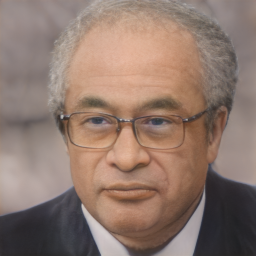
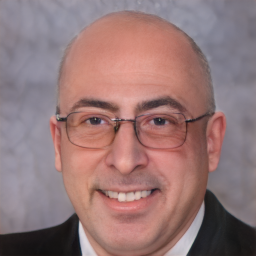
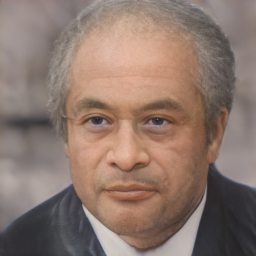

In [19]:
with torch.no_grad():

    recon_pSp_bg = pSp_net.forward(w_pSp_bg, input_code=True, randomize_noise=False, recon_modle=True)
    recon_pSp_t = pSp_net.forward(w_pSp_t, input_code=True, randomize_noise=False, recon_modle=True)

    recon_bg = pSp_net.forward(latent_bg_c, input_code=True, randomize_noise=False, recon_modle=True)
    recon_t = pSp_net.forward(latent_t_c + latent_t_s, input_code=True, randomize_noise=False, recon_modle=True)

    swap_bg = pSp_net.forward(latent_bg_c + latent_t_s, input_code=True, randomize_noise=False, recon_modle=True)
    swap_t = pSp_net.forward(latent_t_c, input_code=True, randomize_noise=False, recon_modle=True)  
n_images = swap_bg.shape[0]

for i in range (n_images):
    display_images(recon_pSp_bg[i,:,:,:], recon_pSp_t[i,:,:,:], recon_bg[i,:,:,:], recon_t[i,:,:,:], swap_bg[i,:,:,:], swap_t[i,:,:,:])

In [5]:
# latent_hdf5_path = '3_code/styleGAN/pSp_encoder_constructive/results/alternative_training/classifiers'
# train_hdf5_path = f"{latent_hdf5_path}/train_latents.h5"
# val_hdf5_path = f"{latent_hdf5_path}/val_latents.h5"

# reproduce_latent_hdf5(cs_mlp_net, pSp_net, train_hdf5_path, val_hdf5_path, opts, device)

In [32]:
import h5py
import torch
hdf5_path = 'results/alternative_training/classifiers/latent_130k/val_latents.h5'
# Open HDF5 file and read first 10 samples
with h5py.File(hdf5_path, "r") as f:
    w_pSp_bg = torch.from_numpy(f["w_pSp_bg"][:4]).to(device) 
    w_pSp_t = torch.from_numpy(f["w_pSp_t"][:4]).to(device) 
    latent_bg_c = torch.from_numpy(f["latent_bg_c"][:4]).to(device)  
    latent_t_c = torch.from_numpy(f["latent_t_c"][:4]).to(device) 
    latent_bg_s = torch.from_numpy(f["latent_bg_s"][:4]).to(device) 
    latent_t_s = torch.from_numpy(f["latent_t_s"][:4]).to(device) 
print(w_pSp_bg.shape)  # Expected: (10, 18, 512)


torch.Size([4, 18, 512])



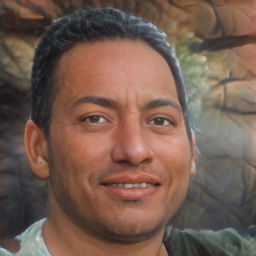
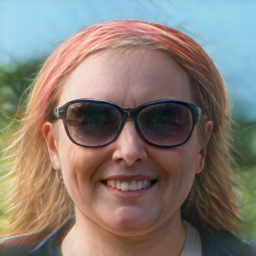
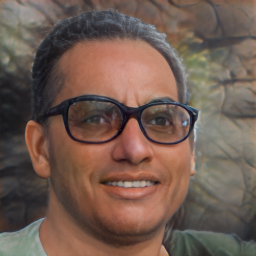
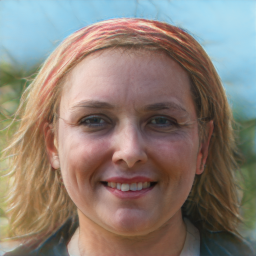


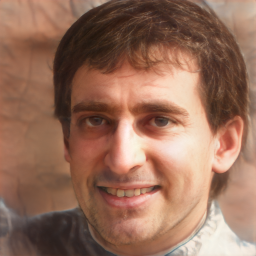
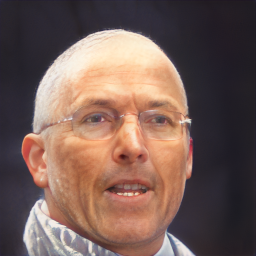
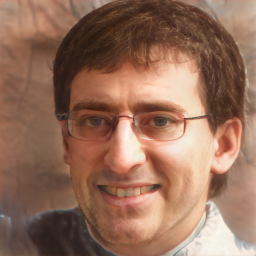
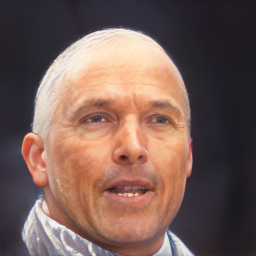


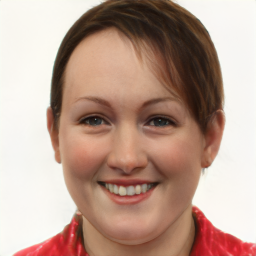
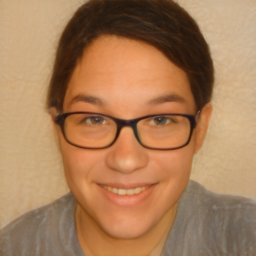
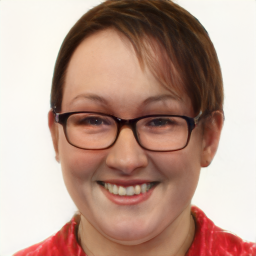
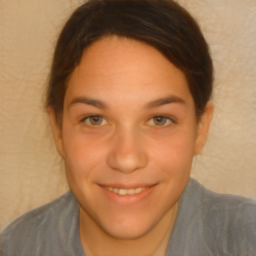


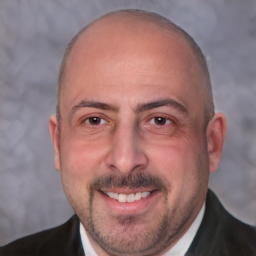
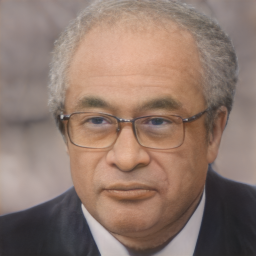
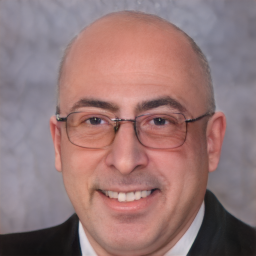
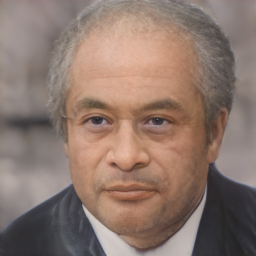

In [33]:
with torch.no_grad():

    # latent_bg_c, latent_bg_s = cs_mlp_net(w_pSp_bg, zero_out_silent=opts.zero_out_silent_bg)
    # latent_t_c, latent_t_s = cs_mlp_net(w_pSp_t, zero_out_silent=opts.zero_out_silent_t) 
    # latent_t_s = 0
    recon_bg = pSp_net.forward(latent_bg_c, input_code=True, randomize_noise=False, recon_modle=True)
    recon_t = pSp_net.forward(latent_t_c + latent_t_s, input_code=True, randomize_noise=False, recon_modle=True)

    swap_bg = pSp_net.forward(latent_bg_c + latent_t_s, input_code=True, randomize_noise=False, recon_modle=True)
    swap_t = pSp_net.forward(latent_t_c, input_code=True, randomize_noise=False, recon_modle=True)  
n_images = swap_bg.shape[0]

for i in range (n_images):
    display_images(recon_bg[i,:,:,:], recon_t[i,:,:,:], swap_bg[i,:,:,:], swap_t[i,:,:,:])


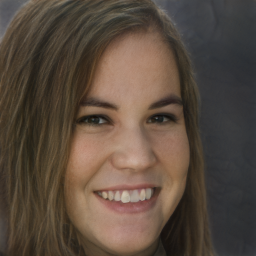
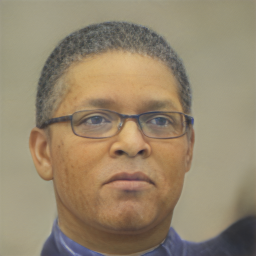
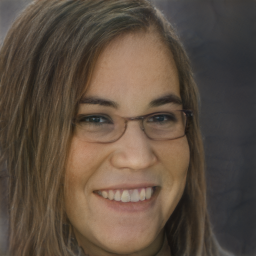
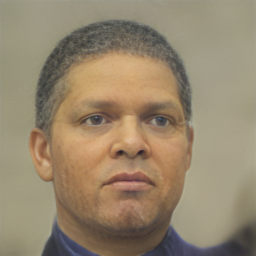


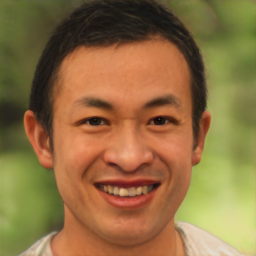
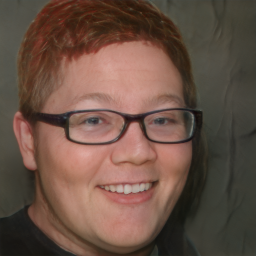
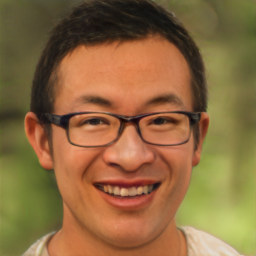
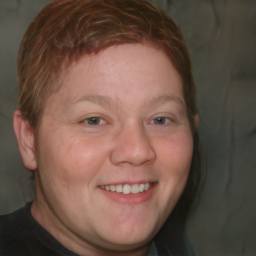


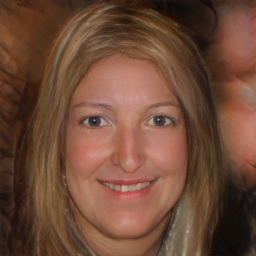
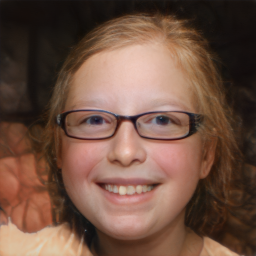
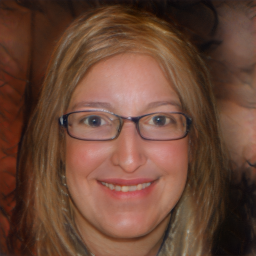
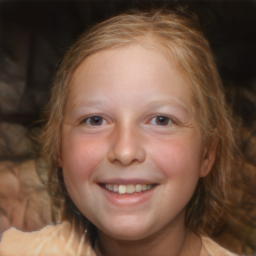


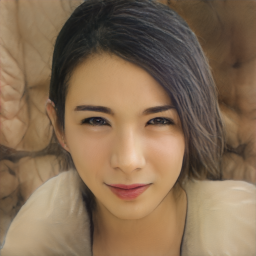
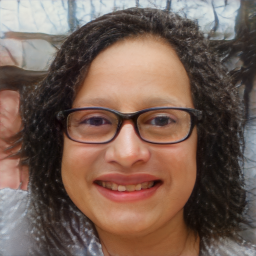
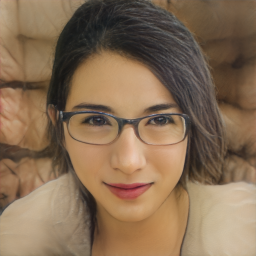
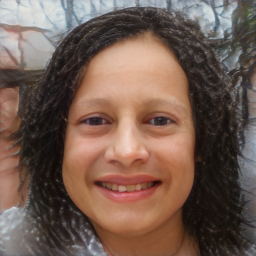

In [34]:

# hdf5_path = "latents.h5"

from base_functions.data_funcs import HDF5LatentClassifierDataset
dataset_c = HDF5LatentClassifierDataset_v2(hdf5_path, label_0="latent_bg_c", label_1="latent_t_c")
dataloader_c = DataLoader(dataset_c, batch_size=4, shuffle=True, num_workers=4, generator=torch.Generator().manual_seed(2321))
dataset_w = HDF5LatentClassifierDataset_v2(hdf5_path, label_0="w_pSp_bg", label_1="w_pSp_t")
dataloader_w = DataLoader(dataset_w, batch_size=4, shuffle=True, num_workers=4, generator=torch.Generator().manual_seed(2321))
# Check one batch
for latent_c, labels in dataloader_c:
    print(f"Latent Shape: {latent_c.shape}")  # (16, 18, 512)
    print(f"Labels: {labels}")  # [0, 1, 0, 1, ...]
    break

for latent_w, labels in dataloader_w:
    print(f"Latent Shape: {latent_c.shape}")  # (16, 18, 512)
    print(f"Labels: {labels}")  # [0, 1, 0, 1, ...]
    break


Latent Shape: torch.Size([4, 18, 512])
Labels: tensor([0, 1, 0, 1])
Latent Shape: torch.Size([4, 18, 512])
Labels: tensor([0, 1, 0, 1])



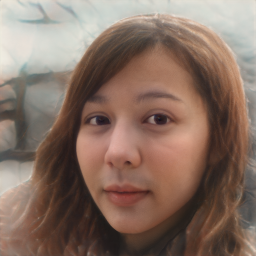
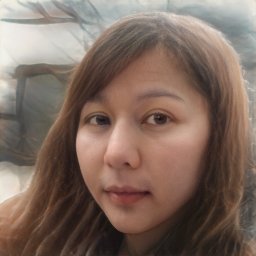


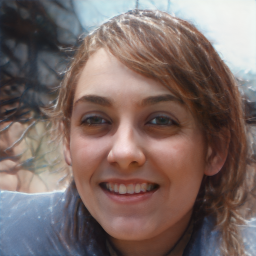
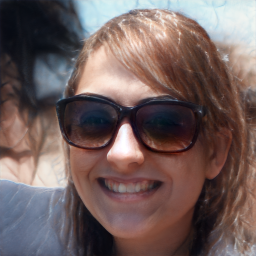


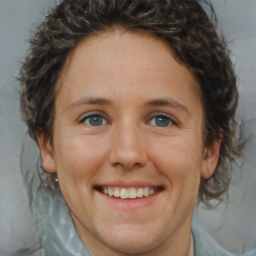
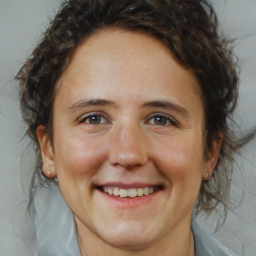


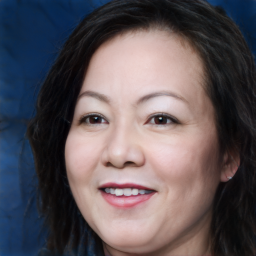
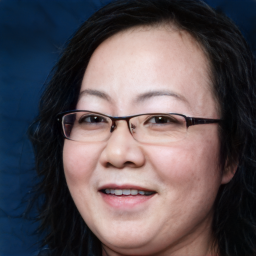

In [35]:
with torch.no_grad():


    # latent_t_s = 0
    recon_c = pSp_net.forward(latent_c.to(device), input_code=True, randomize_noise=False, recon_modle=True)
    recon_w = pSp_net.forward(latent_w.to(device), input_code=True, randomize_noise=False, recon_modle=True)
    
n_images = swap_bg.shape[0]

for i in range (n_images):
    display_images(recon_c[i,:,:,:], recon_w[i,:,:,:])